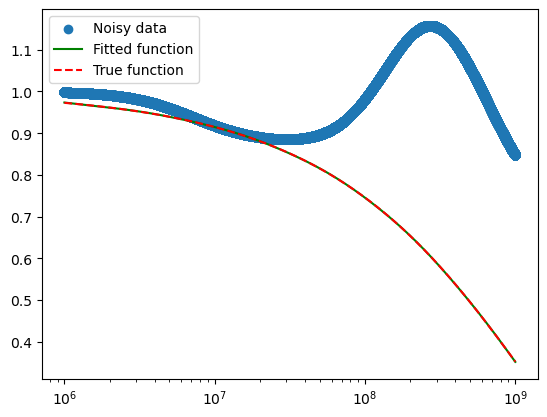

		standard errors  % 
wp1: 6.608e+05 	197 	0.030%
wz1: 6.855e+05 	208 	0.030%
wp2: 5.103e+06 	1.58e+03 	0.031%
wz2: 5.347e+06 	1.7e+03 	0.032%
wp3: 8.381e+07 	2.16e+04 	0.026%
wz3: 9.927e+07 	2.75e+04 	0.028%
wp4: 2.233e+07 	6.53e+03 	0.029%
wz4: 2.44e+07 	7.44e+03 	0.030%
wp5: 2.823e+08 	5.63e+04 	0.020%
wz5: 3.961e+08 	8.55e+04 	0.022%
wp6: 9.023e+08 	8.23e+04 	0.009%

 r1:  1.8711031154136415 
 r2:  2.3843644524140672 
 r3:  9.225490086607468 
 r4: 4.648041745819009 
 r5: 20.159864035313923

 c1: 4.643463645861354e-09 
 c2: 5.953240186126828e-10 
 c3: 3.206465489258858e-11 
 c4: 1.304340919233131e-10 
 c5: 8.03510189758185e-12 
 c6: 3.5277648440749443e-12


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd


# Constants
fmin = 1e6  # minimum frequency (Hz)
fmax = 1e9  # maximum frequency (Hz)
u = 1.26e-6  # magnetic permeability (H/m)
c = 300e6  # speed of light (m/s)
sigma = 58e6  # copper conductivity (S/m)
z0 = 50  # characteristic impedance (Ohms)
er = 2.3  # relative dielectric constant RG58U cable (solid Polyethylene)
tand = 0.00035  # loss tangent/dissipation factor (polyethylene)
w = 2 * np.pi * 4.5e-4  # cross-sectional cable width (m)
l = 30  # line length (m)

# equation 
a1 = (l / (2 * w * z0)) * np.sqrt(np.pi * u / sigma)  # skin effect
a2 = (l * np.pi * tand * np.sqrt(er)) / c  # dielectric effect
# Frequency range
fRange = np.logspace(np.log10(fmin), np.log10(fmax), 650000)#step 650000

f8 = lambda f: np.exp(-a1*np.sqrt(f) - a2*f)
y_f8 = f8(fRange)

# Save response to CSV
data = np.column_stack((fRange, y_f8))
df = pd.DataFrame(data, columns=['Frequency', 'Amplitude'])
df.to_csv('myCSV.csv', index=False)

fscale=1e9

# pole/zero
pz = lambda x,p,z: (1+((2*np.pi*x)/(2*np.pi*z))**2)/(1+((2*np.pi*x)/(2*np.pi*p))**2) 
# pole
p = lambda x,p: 1/(1+((2*np.pi*x)/(2*np.pi*p))**2) # Eq2

# Define our initial estimates
wp1=7e-3*fscale
wz1=8e-3*fscale
wp2=6e-2*fscale
wz2=7e-2*fscale
wp3=2.5e-1*fscale
wz3=3.5e-1*fscale
wp4=.25*fscale
wz4=0.1*fscale
wp5=.5*fscale
wz5=1*fscale
wp6=12*fscale

# Initial guess for the parameters
initial_guess = [wp1,wz1,wp2,wz2,wp3,wz3,wp4,wz4,wp5,wz5,wp6]

# 6-pole fit - cascading 6 pole/zero and one pole utilizing pz(x.p.z) and p(x,p). Where x is the frequency.
def f6(params,freq):
    wp1,wz1,wp2,wz2,wp3,wz3,wp4,wz4,wp5,wz5,wp6 = params

    return np.sqrt(pz(freq,wp1,wz1)*pz(freq,wp2,wz2)*pz(freq,wp3,wz3)*pz(freq,wp4,wz4)*pz(freq,wp5,wz5)*p(freq,wp6))

# need fit by least square method

def residuals(params, x, y):
    return f6(params,x) - y

# Perform the least squares optimization
result = least_squares(residuals, initial_guess, args=(fRange, y_f8))

# Extract the optimized parameters
wp1,wz1,wp2,wz2,wp3,wz3,wp4,wz4,wp5,wz5,wp6 = result.x


# Plot the fitted function
y_fitted = f6(result.x,fRange)
plt.scatter(fRange, f6(initial_guess,fRange), label='Noisy data')
plt.plot(fRange, y_fitted, color='green', label='Fitted function')
plt.plot(fRange, f8(fRange), color='red', linestyle='dashed', label='True function')
plt.xscale("log")
plt.legend()
plt.show()

"""
Calculate the Standard Error
Multiplying all elements of this matrix by the residual variance 
and taking the square root of the diagonal elements 
will give you an estimate of the standard deviation of the fit parameters. 
"""
J = result.jac  # Jacobian matrix at the solution
matrixProduct = np.dot(J.T,J) # matrix product of the transpose of J and J itself
hessian = np.linalg.inv(matrixProduct) # a Gauss-Newton approximation of the Hessian of the cost function.
varRes = np.var(result.fun) #  the variance of the residuals
cov_matrix = hessian * varRes #Multiplying all elements of the Hessian by the residual variance
standard_errors = np.sqrt(np.diag(cov_matrix))

count = 1
print("\t\tstandard errors  % ")
for i in range(len(standard_errors)):
    if i % 2 != 0:
        print(f"wz{count}: {result.x[i]:.4g}",f"\t{standard_errors[i]:.3g} \t{standard_errors[i]/result.x[i]:.3%}")
        count += 1

    else:
        print(f"wp{count}: {result.x[i]:.4g}",f"\t{standard_errors[i]:.3g} \t{standard_errors[i]/result.x[i]:.3%}")


#Pole Zero1
r1= 50*((wz1/wp1)-1);c1=1/(2*np.pi*50*wz1)
#Pole Zero2
r2= 50*((wz2/wp2)-1);c2=1/(2*np.pi*50*wz2)
#Pole Zero3
r3= 50*((wz3/wp3)-1);c3=1/(2*np.pi*50*wz3)
#Pole Zero4
r4= 50*((wz4/wp4)-1);c4=1/(2*np.pi*50*wz4)
#Pole Zero5
r5= 50*((wz5/wp5)-1);c5=1/(2*np.pi*50*wz5)
#Last Pole
c6=1/(2*np.pi*50*wp6)

print("\n r1: ",r1,"\n r2: ",r2,"\n r3: ",r3,"\n r4:",r4,"\n r5:",r5)
print("\n c1:",c1,"\n c2:",c2,"\n c3:",c3,"\n c4:",c4,"\n c5:",c5,"\n c6:",c6)

